### Import Libraries

In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import dask.array as da
import s3fs
import dask
from dask.distributed import Client, LocalCluster

# DASK chunking and parallel processing

In a few words, DASK is an extensive Python library for parallel and distributed computing. Meaning that it allows to parallelise the computations of several tasks and as such utilise the full computing power of a CPU.

It is also integrated within Numpy and Xarray and allows to chunk a data array into smaller pieces (i.e. chunks) that can then be processed in parallel too.

This tutorial is an example of how I used the capabilities of Dask to speed up the visualisation processes of large raster datasets. 

Here, we access a Bathymetric (.Zarr) dataset weighing a total of 22GB, first subset it and and plot 6 different regions of interest for a total of 4.5 GB of data.  

### Using Dask for parallel processing

the first step is to Initialise a Local Dask Cluster and client, This cluster utilises the  CPU resources made available on EDITO the dashboard link allows for simple visualisatoion of your ongoing processing.

In [ ]:
# Create a Dask cluster
cluster = LocalCluster()
client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB', timeout='60s')
client

c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52747 instead
  warnings.warn(
c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52783 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52783/status,
Dashboard: http://127.0.0.1:52783/status,Workers: 4
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52784,Workers: 4
Dashboard: http://127.0.0.1:52783/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:52812,Total threads: 2
Dashboard: http://127.0.0.1:52815/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:52787,


### Access and Open the dataset and inspect using Xarray and Dask

Dask has integrated support for Xarray, as such by specifying the 'chunks' parameter when opening the dataset, the array will automatically be opened as a chunked dask array.

As such, the subsetting steps below will automatically processed the different chunks in parallel.

For additional information and implementation examples of DASK please refer to the library documentation: https://docs.dask.org/en/stable/

For specific examples of using Dask for geoprocessing aditionnal information can be found on Pangeo: https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/dask.html

In [ ]:
# Replace with your online zarr storage for your personal zarr files
host = 'https://s3.waw3-1.cloudferro.com'
bucket = 'emodnet'
arco_location = 'bathymetry/bathymetry_2022.zarr'

# Access the Dataset using xarray and dask
dataset = xr.open_dataset(f"{host}/{bucket}/{arco_location}", chunks='auto') #
dataset

c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset> Size: 66GB
Dimensions:        (latitude: 72000, longitude: 75840)
Coordinates:
  * latitude       (latitude) float64 576kB 15.0 15.0 15.0 ... 90.0 90.0 90.0
  * longitude      (longitude) float64 607kB -36.0 -36.0 -36.0 ... 43.0 43.0
Data variables:
    elevation      (latitude, longitude) float32 22GB dask.array<chunksize=(5625, 5925), meta=np.ndarray>
    elevation_max  (latitude, longitude) float32 22GB dask.array<chunksize=(5625, 5925), meta=np.ndarray>
    elevation_min  (latitude, longitude) float32 22GB dask.array<chunksize=(5625, 5925), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                SeaDataNet_1.0 CF1.6
    EMODnet_Record_Identifier:  ff3aff8a-cff1-44a3-a2c8-1910bf109f85
    GetRecordByIdResponse:      \n  
    Record:                     \n    
    comment:                    The data in the EMODnet Grid should not be us...
    data_rights_constraints:    DO NOT USE FOR NAVIGATION
    ...                         ...
    sci:doi:                    10.12770/ff3aff8a-cff1-44a3-a2c8-1910bf109f85
    source:                     The DTM is a grid of 1/16 * 1/16 arc minute o...
    subject:                    ['/Physical Environment/Bathymetry/Digital Te...
    temporal_extent:            {'end': '2022-07-11T00:00:00', 'start': '1816...
    title:                      EMODnet Digital Bathymetry (DTM 2022)
    type:                       dataset

### Defining regions of interest for subsetting the Bathymetry dataset.

In [ ]:
# Define bounding boxes, vmin, and vmax for different regions within European waters
regions = ['North Sea', 'Eastern Baltic Sea', 'Western Baltic Sea', 'Bay of Biscay', 'Brittany', 'Mediterranean Sea']       # Insert region name
bboxes = [(-2, 8, 50, 60), (17, 30, 55, 62), (7, 18, 53, 60), (-6.5, -0.5, 43,48), (-5.5, -1, 47, 50), (-6, 37, 30, 45.5)]  # Insert BBOX as Follows: [Wlat, Elat, Slon, Nlon) all in degrees.
vmins = [-500, -300, -500, -5000, -300, -5000]                                                                              # insert the max and min boundaries of the plotted colorbar
vmaxes = [0, 0, 0, 0, 0, 0]

### Define the plotting function using ax.imshow 
Using imshow for plotting the dataset has proven to run much faster with DASK than other conventional libraries such as matplotlib and cartopy.

In [ ]:
# Define colors for elevation levels
cmap = 'viridis'

# Function to plot a single chunk of elevation data with actual latitudes and longitudes
@dask.delayed
def plot_regions(chunk, ax, lat, lon, region, vmin, vmax):
    
    im = ax.imshow(chunk, cmap=cmap,interpolation='nearest', origin='lower', extent=(lon[0], lon[-1], lat[0], lat[-1]), vmin=vmin, vmax=vmax)
    
    lon_ticks = lon.values[::int(lon.size / 7)]  
    lat_ticks = lat.values[::int(lat.size / 7)]  
    
    ax.set_xticks(lon_ticks)  
    ax.set_yticks(lat_ticks)   
    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')
    ax.set_title(f'Elevation Map - {region}')
    ax.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=0.5)

    ax.coastlines(resolution='10m')
    cbar = plt.colorbar(im, ax=ax, orientation='vertical',  fraction = 0.025)
    cbar.set_label('Elevation (m)')
   

### Subsetting the dataset and plotting



<xarray.DataArray 'elevation' (latitude: 9600, longitude: 9600)> Size: 369MB
dask.array<getitem, shape=(9600, 9600), dtype=float32, chunksize=(5625, 5925), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 77kB 50.0 50.0 50.0 50.0 ... 60.0 60.0 60.0
  * longitude  (longitude) float64 77kB -1.999 -1.998 -1.997 ... 7.998 7.999
Attributes:
    grid_mapping:        crs
    long_name:           Elevation relative to sea level
    max:                 598.0
    min:                 -6912.60693359375
    sdn_parameter_name:  Sea-floor height (above Lowest Astronomical Tide dat...
    sdn_parameter_urn:   SDN:P01::HGHTALAT
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       geoid_height_above_reference_ellipsoid
    units:               m
<xarray.DataArray 'elevation' (latitude: 6720, longitude: 12480)> Size: 335MB
dask.array<getitem, shape=(6720, 12480), dtype=float32, chunksize=(5625, 5925), chunktype=numpy.ndarray>
Coordinate

2024-07-16 16:21:38,633 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\distributed\utils.py", line 838, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\distributed\dashboard\components\scheduler.py", line 434, in update
    self.root.title.text = title
    ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'str' object has no attribute 'text'
2024-07-16 16:21:38,648 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\Dask_workspace\Lib\site-packages\distributed\utils.py", line 838, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\matteo

KeyboardInterrupt: 

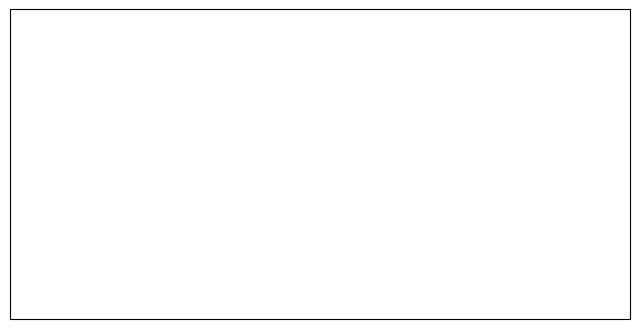

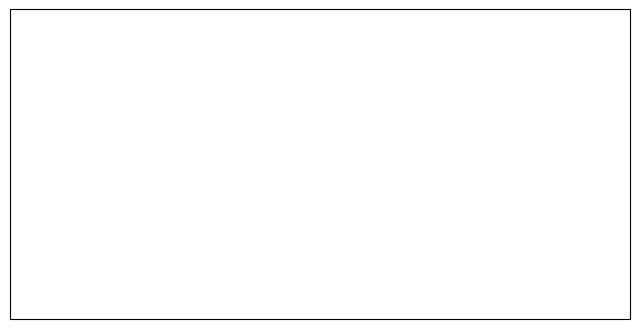

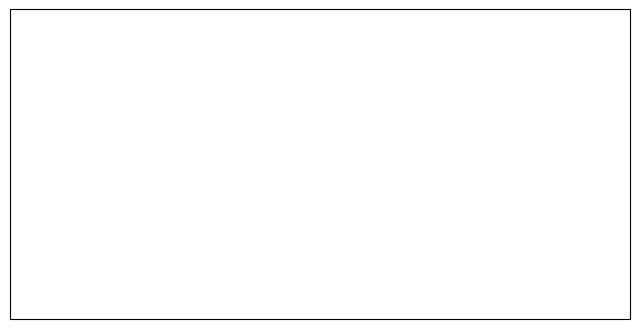

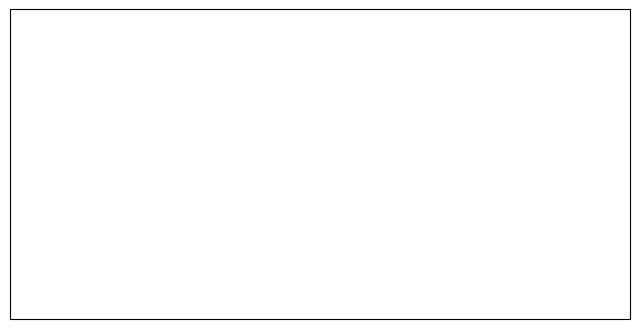

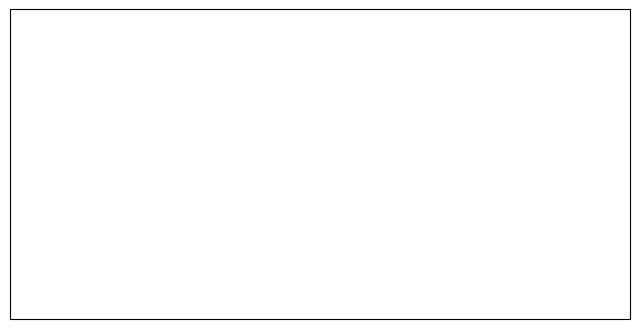

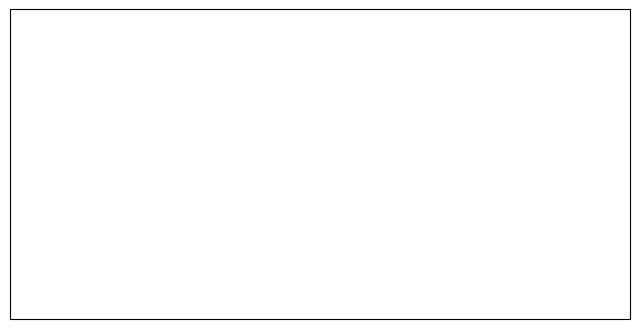

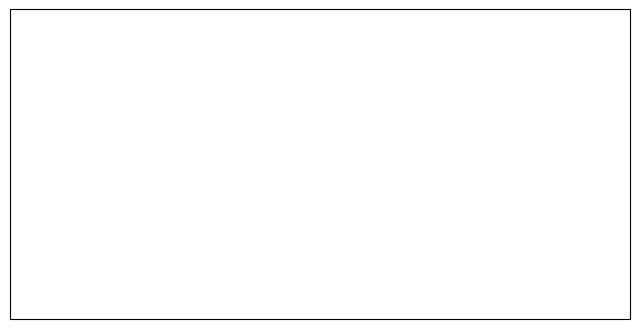

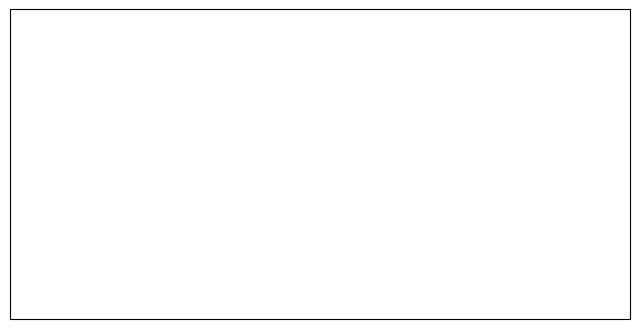

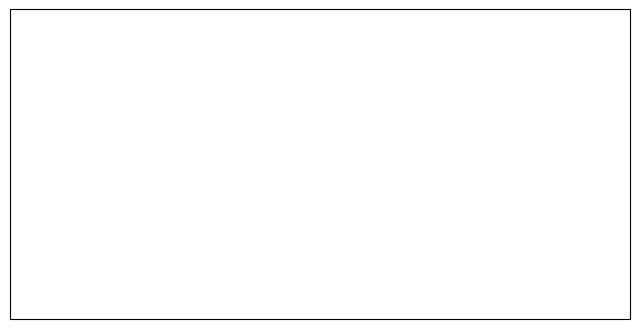

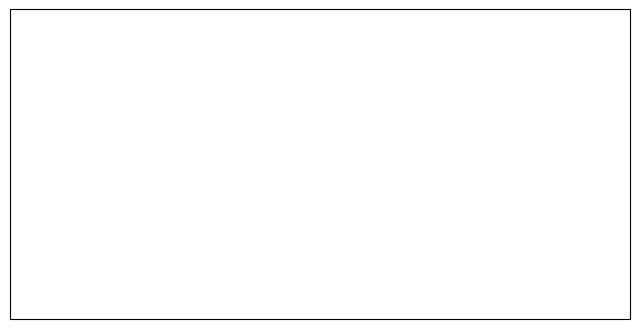

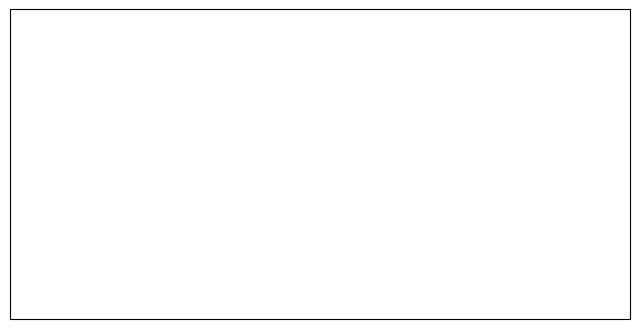

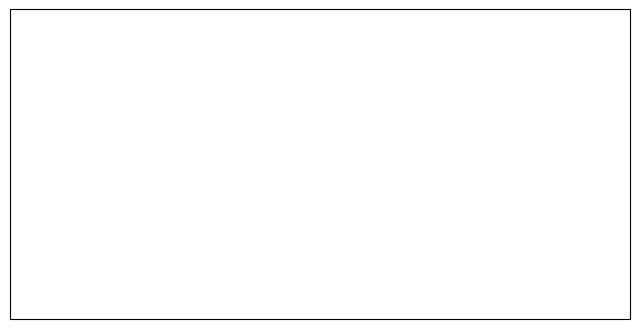

In [9]:
%%time

# Scatter the dataset to the workers
scattered_dataset = client.scatter(dataset)

futures = []

# Loop through each region
for idx, (region, bbox, vmin, vmax) in enumerate(zip(regions, bboxes, vmins, vmaxes)):
    subset_dataset = dataset.sel(latitude=slice(bbox[2], bbox[3]), longitude=slice(bbox[0], bbox[1]))
    dask_array = subset_dataset['elevation']
    print(dask_array)
    
    # Create a figure for each region
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})                                                                       # Call .compute() to process the dataset using the DASK Cluster.
    plot = plot_regions(dask_array, ax, dask_array.latitude, dask_array.longitude, region, vmin, vmax)
    futures.append(plot)

# Compute all futures
dask.compute(*futures)    
    
# Show all plots
for idx, future in enumerate(futures):
    future.result()
    plt.tight_layout()
    #plt.savefig(f"{regions[idx]}_elevation_map.png")                       # Uncomment and specify name and location to save each figure with region name
    plt.show()